## Exploratory Data Analysis del Caso base (para regiones)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.integrate import solve_ivp, quad
import numpy as np
from scipy.misc import derivative as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
fecha_inicio = pd.to_datetime("27-february-2020")
red_traf = 0.7
inicio_red = 25
f = 0.1
# params epidemiológicos
l = 1/3.3
θ = 1/(6.8 - 3.3)
pa, pm, ps = 0.5, 0.476, 0.024
σ = 1/2.4
δ = 1/5.28
ω = 1/4.27
ρ = 1/5
q = 0.0658

## Defunciones

In [3]:
defun = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/datosepi/defunciones_reg.csv",
           index_col = 0);
acumdefun = defun.cumsum(axis = 1).iloc[:, :75]

In [4]:
pob = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/pob_reg.csv", index_col = 0)

In [5]:
pob = pob['pop'].to_list()

Parece que se le puede ajustar una curva logísitca de la forma $f(x) = A + \frac{(K-A)}{C+Qe^{-Bt + J}}$. Habiendo inspeccionado todas las series del tiempo, hay algunas que no se ajustan bien (tienen muy pocos casos y hay un brinco tipo función escalera), suponemos que en estas ciudades no se registraron casos.

In [6]:
D = lambda t, K, C, Q, B, J, A: A + (K-A)/(C+Q*np.exp(-B*t + J))

In [7]:
paramsD = []

for i in range(47):

    try:
        y = acumdefun.iloc[i, :75]
        fit = optimize.curve_fit(D, list(range(20, 95)), y, maxfev=1000)[0]
        paramsD.append(fit)
    except: # los que no se ajustan bien tienen ínidces 17, 28
        paramsD.append([0, 1, 0, 0, 0])

C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_30852\2725270811.py:1: RuntimeWarning: overflow encountered in exp
  D = lambda t, K, C, Q, B, J, A: A + (K-A)/(C+Q*np.exp(-B*t + J))


In [8]:
colores = ['dodgerblue', 'green', 'peru', 'c', 'firebrick']

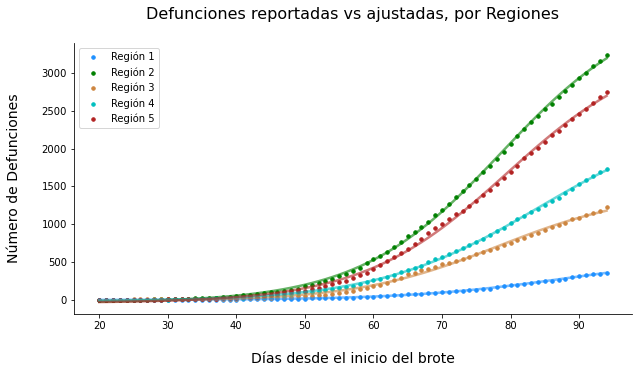

In [9]:
fig, ax = plt.subplots(figsize = (10, 5))
t = np.array(range(20, 95))
for i in range(5):
    ax.plot(t, D(t, *paramsD[i]), color = colores[i], alpha = 0.6, linewidth = 2.5)
    ax.scatter(t, acumdefun.iloc[i], 
            label = 'Región {}'.format(i+1), s = 12, c=colores[i])
    

ax.set_title('Defunciones reportadas vs ajustadas, por Regiones\n', fontsize = 16)
ax.spines['top'].set_visible(False)    
ax.spines['right'].set_visible(False)   
ax.set_ylabel('Número de Defunciones\n', fontsize = 14)
ax.set_xlabel('\nDías desde el inicio del brote\n', fontsize = 14)
ax.legend()

plt.show()

Veamos cómo se ajusta nuestro modelo de defunciones:

De la ecuación diferencial tenemos que $\frac{dD_i}{dt} = q\delta H_i(t) \Rightarrow H_i(t) = \frac{1}{q\delta}\cdot \frac{dD_i}{dt} $

In [10]:
H = lambda t, i: 1/(q*δ) * dt(D, t, n=1, args = (*paramsD[i], ))

Además, $\frac{dH_i}{dt} = \omega I_{ss_i} - q\delta H_i - (1-q)\rho H_i \Rightarrow I_{ss_i}(t) = \frac{1}{\omega}\left(\frac{dH_i}{dt} + \left(q\delta + (1-q)\rho\right)H_i \right)$

In [11]:
Iss = lambda t, i : (dt(H, t, n=1, args = (i,)) + (q*δ + (1-q)*ρ)*H(t, i))/ω

Luego, $\frac{dI_{ss_i}}{dt} = \theta p_s I_{p_i} - \omega I_{ss_i}$, de donde $I_{p_i}(t) = \frac{1}{\theta p_s}\left(\frac{dI_{ss_i}}{dt} + \omega I_{ss_i} \right)$

In [13]:
Ip = lambda t, i: 1/(θ*ps)*(dt(Iss, t, n=1, args = (i, )) + ω*Iss(t, i))

In [14]:
Ip0 = [int(Ip(0, i)) for i in range(5)]

In [15]:
Ip0

[108, 981, 338, 732, 823]

Luego $\frac{dI_{p_i}}{dt} = \ell E_i(t) - \theta I_{p_i}$

$E_i(t) = \frac{1}{\ell}\left(\frac{dI_{p_i}}{dt}+\theta I_{p_i}\right)$

In [17]:
E = lambda t, i: 1/(l)*(dt(Ip, t, n=1, args = (i, )) + θ*Ip(t, i))

In [18]:
E0 = [int(E(0, i)) for i in range(5)]

In [19]:
E0

[133, 1236, 428, 897, 1035]

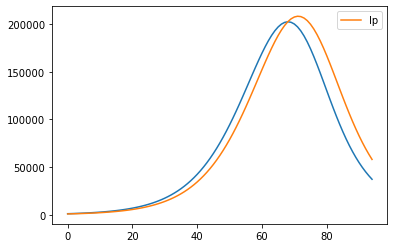

In [20]:
t = np.array(range(95))
plt.plot(t, E(t, 4))
plt.plot(t, Ip(t, 4), label = 'Ip')

plt.legend()
plt.show()

$\frac{dE_i}{dt}= -\frac{dS_i}{dt} - \epsilon E_i$

$S_i(\tau) = -\ell\displaystyle\int_0^\tau E_i(t)\ dt - E_i(\tau) + S_i(0) + E_i(0)$

In [21]:
S = lambda t, i: -l*quad(E, 0, t, args = (i, ))[0] - E(t,i) + (pob[i] - Ip0[i])

In [22]:
T = np.array(range(95))

In [23]:
Sarray = np.zeros((5, 95))

In [24]:
for i in range(5):
    Sarray[i] = [S(t, i) for t in T]

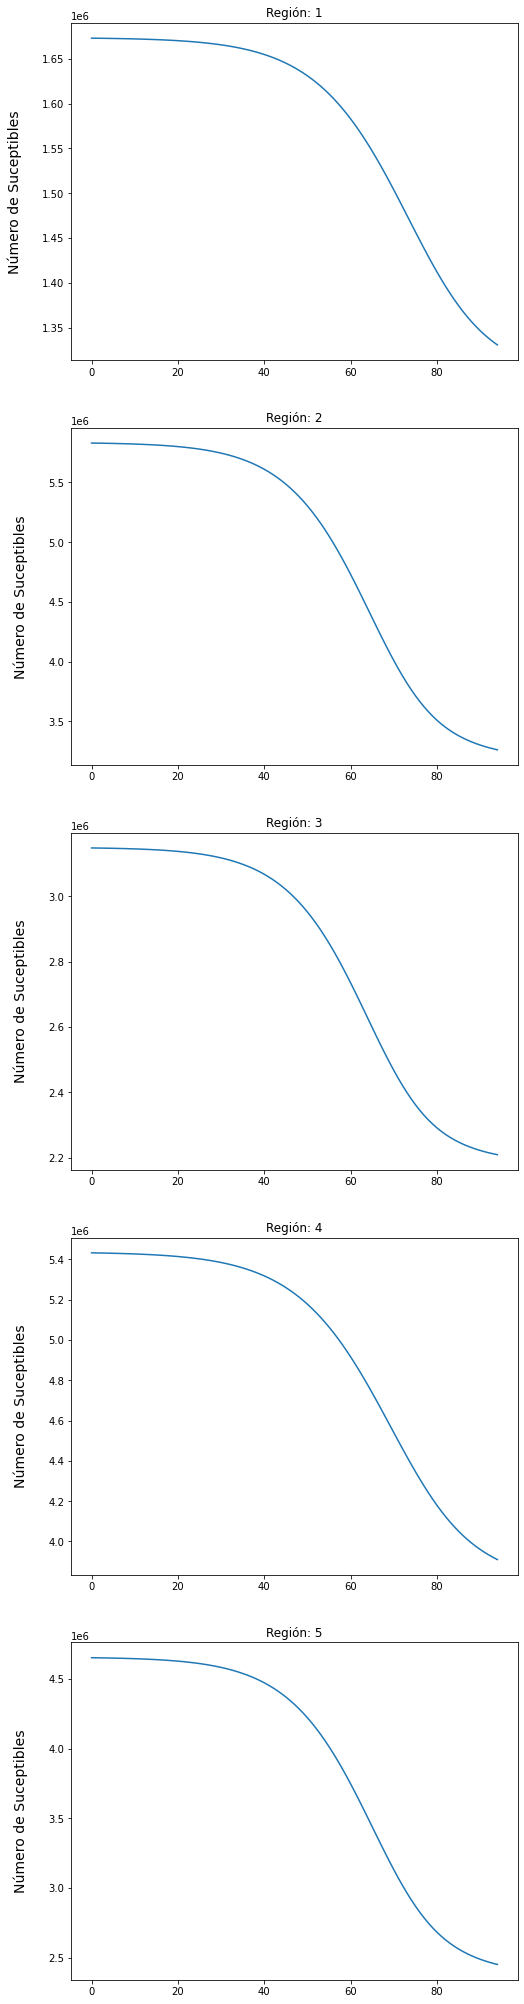

In [25]:
fig, ax = plt.subplots(5, figsize = (8, 36))

t = np.array(range(95))

for i in range(5):
    ax[i].plot(t, Sarray[i])
    ax[i].set_title('Región: {}'.format(i+1))
    ax[i].set_ylabel('Número de Suceptibles\n', fontsize = 14)

Para el resto de los infectados, podemos resolver sus ecuaciones diferenciales de manera numérica:

In [26]:
def IaEDO(t, X):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
        
    dXdt = np.zeros(5)
    
    Ia = lambda i: X[i]
            
    for i in range(5):
        # X_i; los componentes de cada ciudad
                
        # ecuación de los suceptibles para la ciudad i
        dXdt[i] = θ*pa*Ip(t, i) - σ*Ia(i)
            
    return dXdt

tdata = np.linspace(0, 94, 95)
Ia0 = np.zeros(5)
indicesCasos = [0, 4]
Ia0[indicesCasos] = 1


solIa = solve_ivp(IaEDO, (0, 94), Ia0, t_eval = tdata)

In [27]:
Ia = lambda t, i: solIa.y[i, np.array(t).astype(int)]

In [28]:
def ImEDO(t, X):
    """Modelo metapoblacional de la dinámica del covid-19 por Calvetti, et. al. Establece el sistema de edo para los parámetros
    mu en R y Br en R^n."""
        
    dXdt = np.zeros(5)
    
    Im = lambda i: X[i]
            
    for i in range(5):
        # X_i; los componentes de cada ciudad
                
        # ecuación de los suceptibles para la ciudad i
        dXdt[i] = θ*pm*Ip(t, i) - σ*Im(i)
            
    return dXdt

tdata = np.linspace(0, 94, 95)
Im0 = np.zeros(5)

solIm = solve_ivp(ImEDO, (0, 94), Im0, t_eval = tdata)

In [29]:
Im = lambda t, i: solIm.y[i, np.array(t).astype(int)]

$-\ell E_i - \frac{dE_i}{dt} = -\lambda_i(t)S_i \Rightarrow \lambda_i(t) = \frac{\ell E_i}{S_i} + \frac{\frac{dE_i}{dt}}{S_i}$

In [30]:
λ = lambda t, i: (dt(E, t, n = 1, args = (i, )) + l*E(t,i) )/ Sarray[i, t]

In [31]:
es = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/viajes/viajes_es_reg.csv",
                index_col = 0)

s = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/viajes/viajes_s_reg.csv",
                index_col = 0)

d = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/viajes/viajes_d_reg.csv",
                index_col = 0)

In [32]:
dfx0 = {'Ip0':Ip0, 'E0': E0}

In [33]:
df = pd.DataFrame(dfx0)

In [34]:
df.index = es.index

In [33]:
df.to_csv("D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/cleandata/x0_reg.csv")

In [35]:
inicio_red = 25

Intento para ajustar la fuerza de infección del modelo de calveti:

In [36]:
viajes = [es, s, d]

In [39]:
N = lambda t, i: pob[i] - D(t, *paramsD[i])

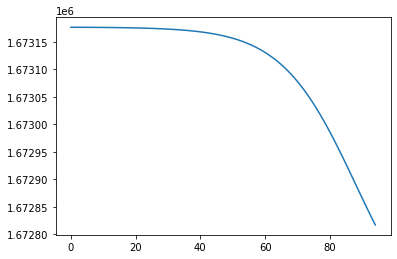

In [40]:
t = np.array(range(95))
plt.plot(t, N(t, 0))

In [41]:
γ = lambda t, i: N(t, i) / N(0, i)
γ = np.vectorize(γ)

N = np.vectorize(N)

In [42]:
def Ω(i, j, d):
    wd = (fecha_inicio.weekday() + d) % 7
    if wd == 5:
        if i == j:
            p = (N(d, i) - γ(d, i)*sum([viajes[1].iloc[i, k] if k!=i else 0 for k in range(5)] ))/ N(d, i)
        else: 
            p = γ(d, i)*viajes[1].iloc[i, j] / N(d, i)
        
    elif wd == 6:
        if i == j:
            p = (N(d, i) - γ(d, i)*sum([viajes[2].iloc[i, k] if k!=i else 0 for k in range(5)] ))/ N(d, i)
        else:
            p = γ(d, i)*viajes[2].iloc[i, j] / N(d, i)
                 
    else:
        if i == j:
            p = (N(d, i) - γ(d, i)*sum([viajes[0].iloc[i, k] if k!=i else 0 for k in range(5)] ))/ N(d, i)
        else:
            p = γ(d, i)*viajes[0].iloc[i, j] / N(d, i)
        
    if d > inicio_red:
        p = (1-red_traf)*p
                
    return p

In [43]:
Ω = np.vectorize(Ω)

In [44]:
Ω(0, 0, 0)

array(-1.36943819)

In [45]:
f

0.1

In [46]:
def L(t, i):
    return sum((β(t, k)* Ω(i, k, t) * sum(( Ω(m, k, t) * (Ip(t, m) + Ia(t, m) + f*Im(t, m))  for m in range(5) ))  for k in range(5)))

In [47]:
sols = []

In [48]:
for t in range(95):
    A = np.zeros((5, 5))
    b = np.zeros(5)
    for i in range(5):
        for j in range(5):
            A[i, j] = Ω(i, j, t)* sum(( Ω(m, j, t) * (Ip(t, m) + Ia(t, m) + f*Im(t, m))  for m in range(5)))
        b[i] = λ(t, i)
    X = np.linalg.lstsq(A, b, rcond = None)[0]
    sols.append(X)

In [49]:
Sols = np.array(sols)

In [50]:
len(Sols)

95

In [51]:
def β(t, k, Θ = Sols):
    return Θ[int(t), k]

β = np.vectorize(β)

In [52]:
β(90, 0)

array(1.04018419e-06)

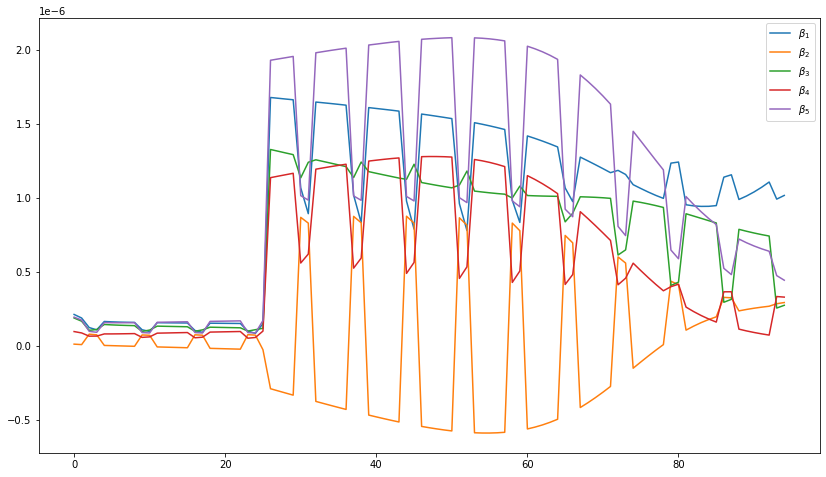

In [53]:
fig, ax = plt.subplots(figsize = (14, 8))

for i in range(5):
    ax.plot(Sols[:, i], label = r'$\beta_{}$'.format(i+1))
    
ax.legend()
plt.show()

In [54]:
Sols.shape

(95, 5)

In [55]:
L(40, 0)
λ(80, 0)

0.0059273860668013064

In [56]:
L(80, 0)

0.0059273860668013064

In [57]:
red_traf = 0.7

In [213]:
pd.DataFrame(Sols).to_csv('D:/Edgar Trejo/Universidad/Proyecto/COVID19Model/data/cleandata/params.csv', index=False)

In [109]:
def Model(t, X):
    
    dXdt = np.zeros(5*8)
    
    S = lambda i: X[8*i + 0]
    E = lambda i: X[8*i + 1]
    Ip = lambda i: X[8*i + 2]
    Iss =  lambda i: X[8*i + 3]
    H = lambda i: X[8*i + 4]
    D = lambda i: X[8*i + 5]
    Ia = lambda i: X[8*i + 6]
    Im = lambda i: X[8*i + 7]
    
    N = lambda i: pob[i] - D(i)
    γ = lambda i: N(i) / pob[i]
    
    
    def Ω(i, j, d):
        wd = (fecha_inicio.weekday() + d) % 7
        if wd == 5:
            if i == j:
                p = (N(i) - γ(i)*(sum(viajes[1].iloc[i, :]) - viajes[1].iloc[i, i]))/ N(i)
            else: 
                p = γ(i)*viajes[1].iloc[i, j]/ N(i)

        elif wd == 6:
            if i == j:
                p = (N(i) - γ(i)*(sum(viajes[2].iloc[i, :]) - viajes[1].iloc[i, i]))/ N(i)
            else:
                p = γ(i)*viajes[2].iloc[i, j]/ N(i)

        else:
            if i == j:
                p = (N(i) - γ(i)*(sum(viajes[0].iloc[i, :]) - viajes[1].iloc[i, i]))/ N(i)
            else:
                p = γ(i)*viajes[0].iloc[i, j]/ N(i)

        if d > inicio_red:
            p = (1-red_traf)*p 

        return p
    
    def L(t, i):
        return sum((β(t, k)* Ω(i, k, t) * sum(( Ω(m, k, t) * (Ip(m) + Ia(m) + f*Im(m)) for m in range(5) )) for k in range(5)))
            
    
    for i in range(5):    
        # X_i; los componentes de cada ciudad
        # ecuación de los suceptibles para la ciudad i
        fuerza = L(t, i)
        dXdt[8*i + 0] = -fuerza*S(i)
        # ecuación de los expuestos para la ciudad i
        dXdt[8*i + 1] = fuerza*S(i) - l*E(i)
        # ecuación para los pre-infectados
        dXdt[8*i + 2] = l*E(i) - θ*Ip(i)
        # ecuación para los infectados severos
        dXdt[8*i + 3] = θ*ps*Ip(i) - ω*Iss(i)
        # ecuación para los hospitalizados
        dXdt[8*i + 4] = ω*Iss(i) - (1-q)*ρ*H(i) - δ*q*H(i)
        # ecuación de los difuntos
        dXdt[8*i + 5] = q*δ*H(i)
        # ecuación de los asintomáticos
        dXdt[8*i + 6] = θ*pa*Ip(i) - σ*Ia(i)
        # ecuación de los mild sym
        dXdt[8*i + 7] = θ*pm*Ip(i) - σ*Im(i)

    return dXdt

In [102]:
x0df = pd.read_csv("https://raw.githubusercontent.com/edtrelo/COVID19Model/main/data/cleandata/x0_reg.csv", index_col = 0)

In [103]:
x0 = []
indicesCasos = [0, 4]

for i in range(5):
    if i in indicesCasos:
        x0.extend([pob[i]-x0df.iloc[i, 0]-x0df.iloc[i, 1]-1, x0df.iloc[i, 1], x0df.iloc[i, 0], 0, 0, 0, 1, 0])
    else:
        x0.extend([pob[i]-x0df.iloc[i, 0]-x0df.iloc[i, 1], x0df.iloc[i, 1], x0df.iloc[i, 0], 0, 0, 0, 0, 0])

In [110]:
def solucionar():
        """Función que ocupamos para obtener la solución del sistema y que va 
        a ajustarse a los datos."""

        t = np.array(range(95))
    
        solu = solve_ivp(Model, (0, 95), x0, t_eval = t)
        
    
        return solu

Solución del caso base:

In [111]:
s = solucionar()

In [115]:
len(s.y[0])

32

In [230]:
len(s[0])

1

In [151]:
camas = np.array(pob)/1000

In [152]:
camas

array([1673.172, 5831.096, 3148.49 , 5433.705, 4654.189])

C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_15620\662193037.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,0].set_yticklabels(['-20', '0', '20', '40', '60', '80', '100', '120', '140'])


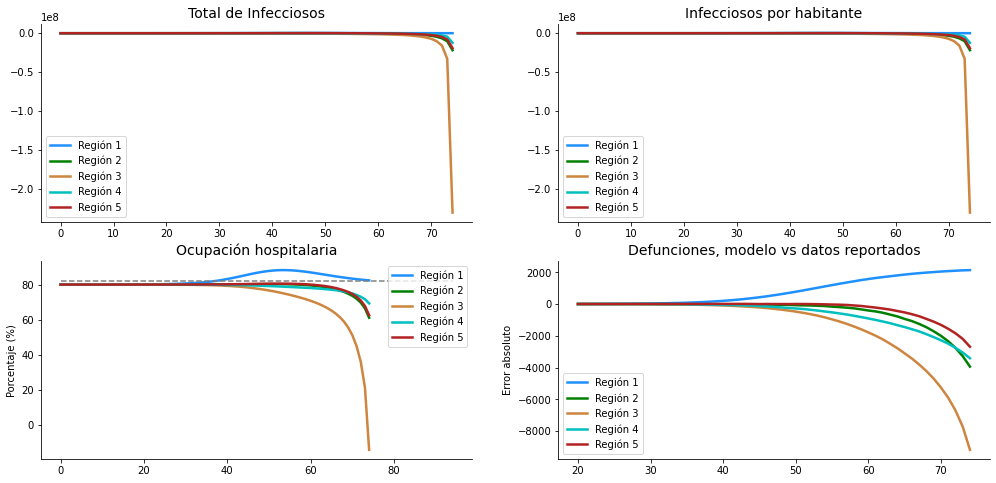

In [167]:
t  = np.array(range(94))

fig, ax = plt.subplots(2, 2, figsize = (17, 8))

for i in range(5):
    ax[0, 0].plot(s[8*i + 6] + s[8*i + 7] + s[8*i + 2], label = 'Región {}'.format(i+1), color = colores[i], linewidth = 2.5)
    ax[0, 1].plot((s[8*i + 6] + s[8*i + 7] + s[8*i + 2]),  label = 'Región {}'.format(i+1), color = colores[i], linewidth = 2.5)
    ax[1, 0].plot(s[8*i + 4]/ camas[i], color = colores[i], label = 'Región {}'.format(i+1), linewidth = 2.5)
    ax[1, 1].plot(range(20, 75), (s[8*i + 5,20: ] - acumdefun.iloc[i, :55]), color = colores[i], linewidth = 2.5, 
                 label = 'Región {}'.format(i+1))

    

ax[0,0].set_title('Total de Infecciosos', fontsize = 14)   
ax[0,1].set_title('Infecciosos por habitante', fontsize = 14)  
ax[1,0].set_title('Ocupación hospitalaria', fontsize = 14)
ax[1,1].set_title('Defunciones, modelo vs datos reportados', fontsize = 14)  

ax[1,0].set_ylabel('Porcentaje (%)')
ax[1,1].set_ylabel('Error absoluto')

for a in ax.ravel():
    a.legend()
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    
ax[1,0].set_yticklabels(['-20', '0', '20', '40', '60', '80', '100', '120', '140'])
ax[1,0].hlines(1.0, 0, 94, linestyle = '--', color = 'grey')
    
plt.show()

In [546]:
infecciosos = np.array([s[8*i + 6] + s[8*i + 7] + s[8*i + 2] for i in range(5)])

In [548]:
np.argmax(infecciosos, axis = 1)

array([77, 73, 71, 76, 73], dtype=int64)

In [554]:
sum(abs(np.array([s[8*i + 5, 20:]- acumdefun.iloc[i, :-1] for i in range(5)])).ravel() )/ len(abs(np.array([s[8*i + 5, 20:]- acumdefun.iloc[i, :-1] for i in range(5)])).ravel() )

46.76925576030984

In [543]:
casobase = s

## Diferentes magnitudes en las reducciones

In [558]:
reds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [568]:
len(reds)

11

In [559]:
solsRed = []

In [560]:
for r in reds:
    red_traf = r
    y = sol(x0)
    solsRed.append(y)

In [569]:
indices = [0, 2, 4, 6, 8, 10]

In [ ]:
N = lambda t, i: pob[i] - 

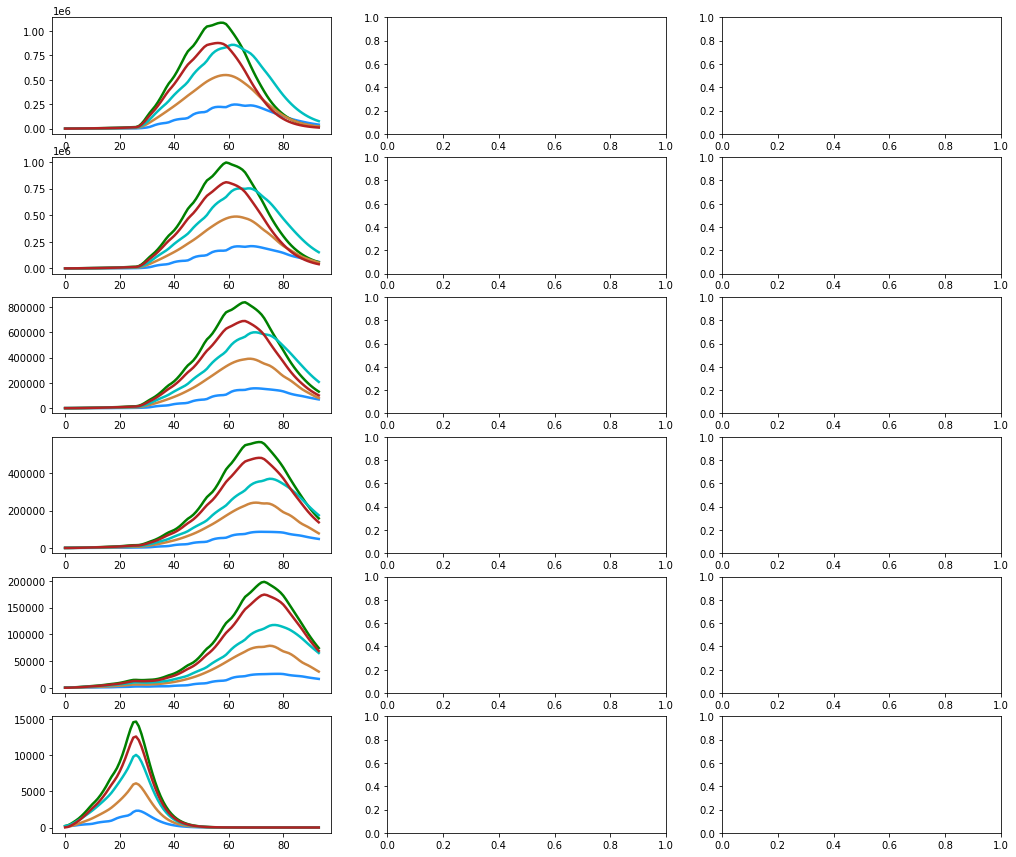

In [572]:
t  = np.array(range(94))

fig, ax = plt.subplots(6, 3, figsize = (17, 15))

for i in range(len(indices)):
    s = solsRed[indices[i]]
    for j in range(5):
        ax[i, 0].plot((s[8*j + 6] + s[8*j + 7] + s[8*j + 2])/, label = 'Región {}'.format(j+1), color = colores[j], linewidth = 2.5)

C:\Users\Edgar Trejo\AppData\Local\Temp\ipykernel_20824\3137318856.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,0].set_yticklabels(['-20', '0', '20', '40', '60', '80', '100', '120', '140'])


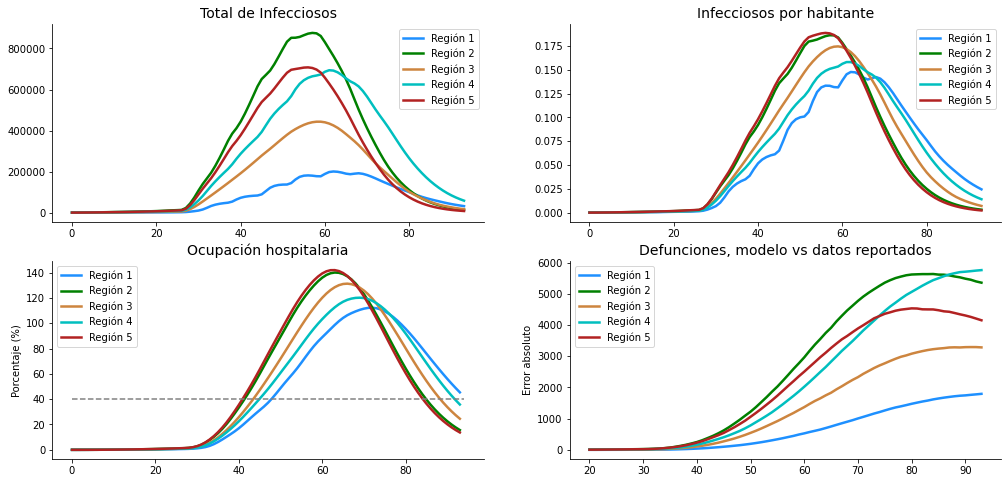

In [563]:
t  = np.array(range(94))

fig, ax = plt.subplots(2, 2, figsize = (17, 8))

for i in range(5):
    ax[0, 0].plot(solsRed[0][8*i + 6] + [8*i + 7] + solsRed[0][8*i + 2], label = 'Región {}'.format(i+1), color = colores[i], linewidth = 2.5)
    ax[0, 1].plot((solsRed[0][8*i + 6] + solsRed[0][8*i + 7] + solsRed[0][8*i + 2])/N(t,i),  label = 'Región {}'.format(i+1), color = colores[i], linewidth = 2.5)
    ax[1, 0].plot(solsRed[0][8*i + 4]/ camas[i], color = colores[i], label = 'Región {}'.format(i+1), linewidth = 2.5)
    ax[1, 1].plot(range(20, 94), (solsRed[0][8*i + 5, 20:]- acumdefun.iloc[i, :-1]), color = colores[i], linewidth = 2.5, 
                 label = 'Región {}'.format(i+1))

    

ax[0,0].set_title('Total de Infecciosos', fontsize = 14)   
ax[0,1].set_title('Infecciosos por habitante', fontsize = 14)  
ax[1,0].set_title('Ocupación hospitalaria', fontsize = 14)
ax[1,1].set_title('Defunciones, modelo vs datos reportados', fontsize = 14)  

ax[1,0].set_ylabel('Porcentaje (%)')
ax[1,1].set_ylabel('Error absoluto')

for a in ax.ravel():
    a.legend()
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    
ax[1,0].set_yticklabels(['-20', '0', '20', '40', '60', '80', '100', '120', '140'])
ax[1,0].hlines(1.0, 0, 94, linestyle = '--', color = 'grey')
    
plt.show()